In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model

import utils
import datetime
import os
np.random.seed(42)

#  XGBoost

Defining constants

In [2]:
#person = 'Davis'
person = 'JOURNEY HOUSE TRAVEL INC'
cat_vars = ['Merchant Category Code (MCC)']
numeric_vars = ['Amount']
categories = ['Cardholder Last Name', 'Cardholder First Initial'] + numeric_vars + cat_vars
num_rounds = 20
params = {
    'max_depth':         12,
    'max_leaves':        2**12,
    'alpha':             0.9,
    'eta':               0.1,
    'gamma':             0.1,
    'learning_rate':     0.1,
    'subsample':         1,
    'reg_lambda':        1,
    'scale_pos_weight':  2,
    'tree_method':       'gpu_hist',
    'objective':         'binary:logistic',
}

In [3]:
df = utils.get_df()

In [4]:
transations = utils.get_person_balanced_df(df, person, categories, cat_vars, numeric_vars)
df_transations = transations[0][0]
labels = transations[1][0]

Training model

In [5]:
x_train, x_test, y_train, y_test = train_test_split(df_transations, labels, test_size=.25, random_state=42)
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
evals = [(dtest, 'test'), (dtrain, 'train')]

In [6]:
model = xgb.train(params, dtrain, num_rounds, evals=evals)

[0]	test-logloss:0.60655	train-logloss:0.60644
[1]	test-logloss:0.53576	train-logloss:0.53563
[2]	test-logloss:0.47691	train-logloss:0.47676
[3]	test-logloss:0.42743	train-logloss:0.42718
[4]	test-logloss:0.38545	train-logloss:0.38505
[5]	test-logloss:0.34941	train-logloss:0.34893
[6]	test-logloss:0.31839	train-logloss:0.31781
[7]	test-logloss:0.29147	train-logloss:0.29087
[8]	test-logloss:0.26807	train-logloss:0.26745
[9]	test-logloss:0.24763	train-logloss:0.24705
[10]	test-logloss:0.22983	train-logloss:0.22921
[11]	test-logloss:0.21414	train-logloss:0.21356
[12]	test-logloss:0.20051	train-logloss:0.19985
[13]	test-logloss:0.18846	train-logloss:0.18780
[14]	test-logloss:0.17770	train-logloss:0.17707
[15]	test-logloss:0.16842	train-logloss:0.16775
[16]	test-logloss:0.16008	train-logloss:0.15941
[17]	test-logloss:0.15274	train-logloss:0.15207
[18]	test-logloss:0.14639	train-logloss:0.14568
[19]	test-logloss:0.14100	train-logloss:0.14011


Test Model

In [7]:
threshold = .5
true_labels = y_test.astype(int)
true_labels.sum()

2420

In [8]:
preds = model.predict(dtest)
pred_labels = (preds > threshold).astype(int)

In [9]:
pred_labels.sum()

2490

In [10]:
auc = roc_auc_score(true_labels, preds)
print('Auc:', auc)
print ('Accuracy:', accuracy_score(true_labels, pred_labels))

Auc: 0.9863156990429719
Accuracy: 0.9751295336787564


Confusion Matrix :


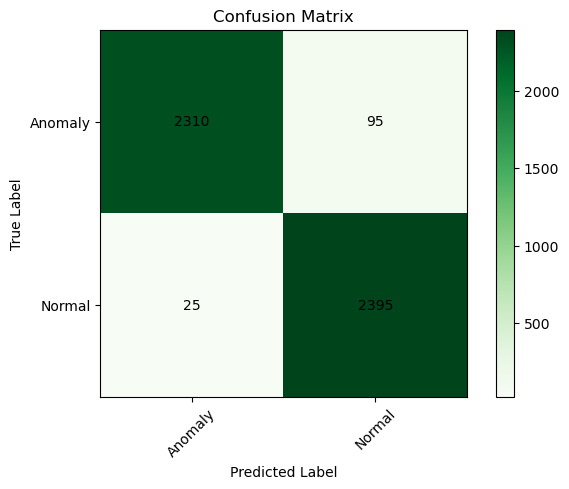

In [11]:
results = confusion_matrix(true_labels, pred_labels) 

print ('Confusion Matrix :')

utils.plot_confusion_matrix(results, ['Anomaly','Normal'])

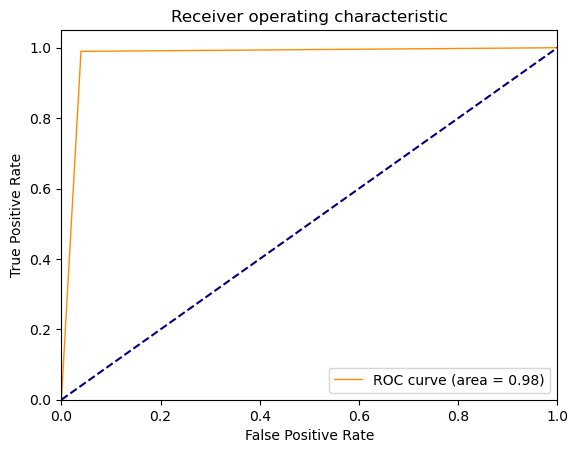

In [12]:
fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, pred_labels)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

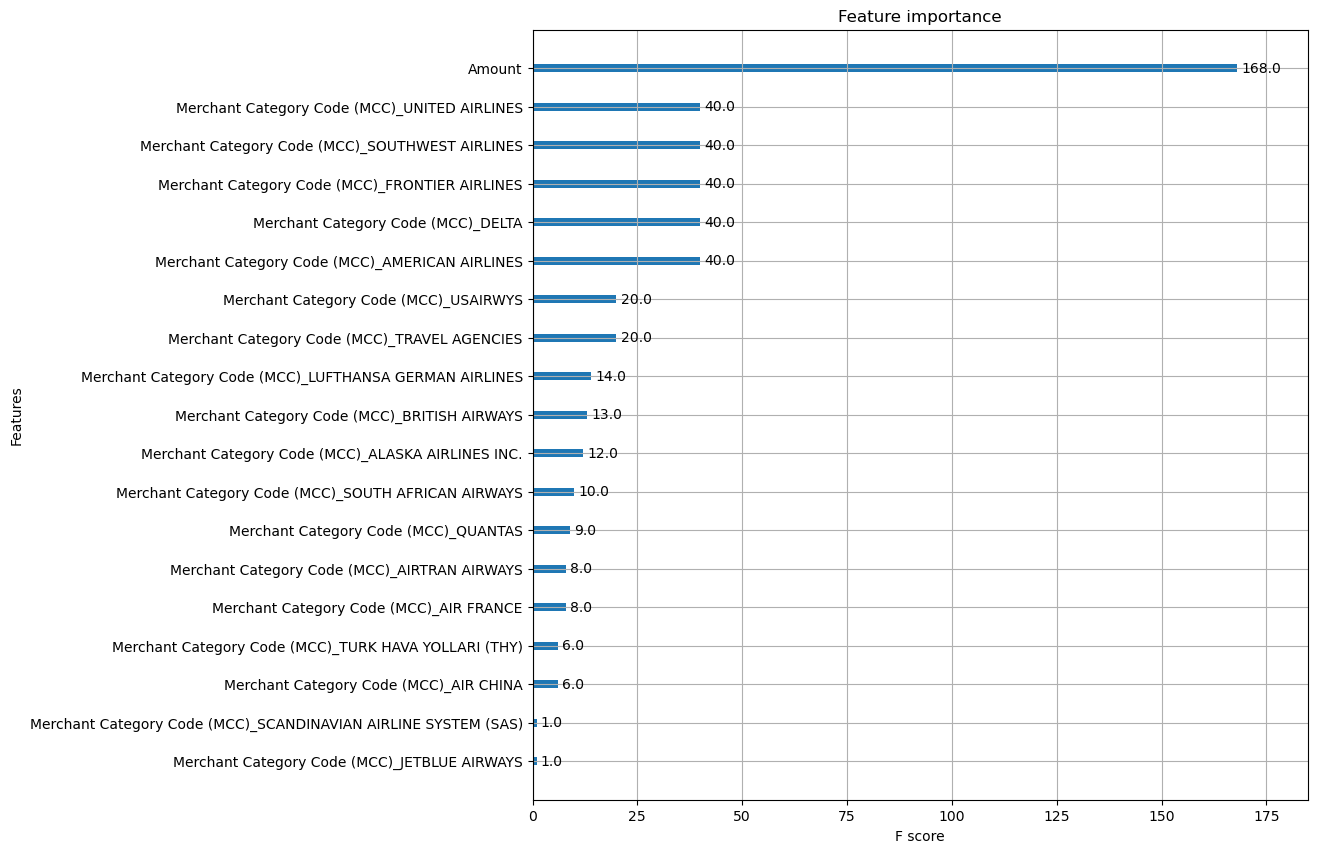

In [13]:
ax = xgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(10, 10)

# Tunning Hyperparams

In [14]:
params = {
    'eta':               0.1,
    'gamma':             0.1,
    'max_depth':         12,
    'reg_alpha':         0.9,
    'subsample':         1,
    'learning_rate':     0.1,
    'reg_lambda':        1,
    'tree_method':       'gpu_hist',
    'objective':         'binary:logistic',
}

In [15]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={'max_depth': hp.quniform("max_depth", 6, 18, 1),
        'gamma': hp.uniform ('gamma', 0,20),
        'learning_rate': hp.uniform ('learning_rate', 0.01, 0.2),
        'subsample': hp.uniform ('subsample', 0.1,1.0),
        'eta': hp.uniform ('eta', 0.01,0.2),        
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'n_estimators': 1800,
        'seed': 0
    }

In [16]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], 
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    eta = space['eta'],
                    reg_lambda = space['reg_lambda'],
                    subsample = space['subsample'],
                    learning_rate = space['learning_rate'],
                    reg_alpha = int(space['reg_alpha']),
                    eval_metric="auc",
                    early_stopping_rounds=10
                    )
    
    evaluation = [( x_train, y_train), ( x_test, y_test)]
    
    clf.fit(x_train, y_train, eval_set=evaluation, verbose=False)
    

    pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.960621761658031                                      
SCORE:                                                                           
0.9500518134715026                                                               
SCORE:                                                                           
0.9624870466321244                                                               
SCORE:                                                                            
0.9546113989637306                                                                
SCORE:                                                                            
0.9515025906735751                                                                
SCORE:                                                                            
0.9523316062176166                                                                
SCORE:                                                        

In [29]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
for param in best_hyperparams:
    params[param] = best_hyperparams[param]

The best hyperparameters are :  

{'eta': 0.018106917248781107, 'gamma': 0.8276632707936512, 'learning_rate': 0.18062994168859867, 'max_depth': 17.0, 'reg_alpha': 49.0, 'reg_lambda': 0.735233177259954, 'subsample': 0.9362976958867139}


In [30]:
transations = utils.get_person_balanced_df(df, person, categories, cat_vars, numeric_vars)
df_transations = transations[0][0]
labels = transations[1][0]
x_train, x_test, y_train, y_test = train_test_split(df_transations, labels, test_size=.25, random_state=42)
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
evals = [(dtest, 'test'), (dtrain, 'train')]

In [31]:
model = xgb.train(params, dtrain, num_rounds, evals=evals)

[0]	test-logloss:0.55247	train-logloss:0.55252
[1]	test-logloss:0.45651	train-logloss:0.45654
[2]	test-logloss:0.38546	train-logloss:0.38543
[3]	test-logloss:0.33171	train-logloss:0.33160
[4]	test-logloss:0.28995	train-logloss:0.28975
[5]	test-logloss:0.25730	train-logloss:0.25701
[6]	test-logloss:0.23159	train-logloss:0.23122
[7]	test-logloss:0.21116	train-logloss:0.21069
[8]	test-logloss:0.19476	train-logloss:0.19425
[9]	test-logloss:0.18177	train-logloss:0.18116
[10]	test-logloss:0.17391	train-logloss:0.17303
[11]	test-logloss:0.16485	train-logloss:0.16392
[12]	test-logloss:0.15955	train-logloss:0.15846
[13]	test-logloss:0.15323	train-logloss:0.15209
[14]	test-logloss:0.14963	train-logloss:0.14839
[15]	test-logloss:0.14703	train-logloss:0.14557
[16]	test-logloss:0.14449	train-logloss:0.14300
[17]	test-logloss:0.14080	train-logloss:0.13929
[18]	test-logloss:0.13915	train-logloss:0.13759
[19]	test-logloss:0.13733	train-logloss:0.13567


In [32]:
transations_val_2 = utils.get_person_total_df(df, person, categories, cat_vars, numeric_vars)
df_transations_val_2 = transations_val_2[0][0]
labels_val_2 = transations_val_2[1][0]

In [33]:
dtest_val = xgb.DMatrix(df_transations_val_2, label=labels_val_2)

In [34]:
true_labels = y_test.astype(int)
preds_val = model.predict(dtest_val)
pred_labels_val = (preds_val > threshold).astype(int)

In [35]:
auc = roc_auc_score(true_labels, preds)
print('Auc:', auc)
print ('Accuracy:', accuracy_score(true_labels, pred_labels))

Auc: 0.9863156990429719
Accuracy: 0.9751295336787564


Confusion Matrix :


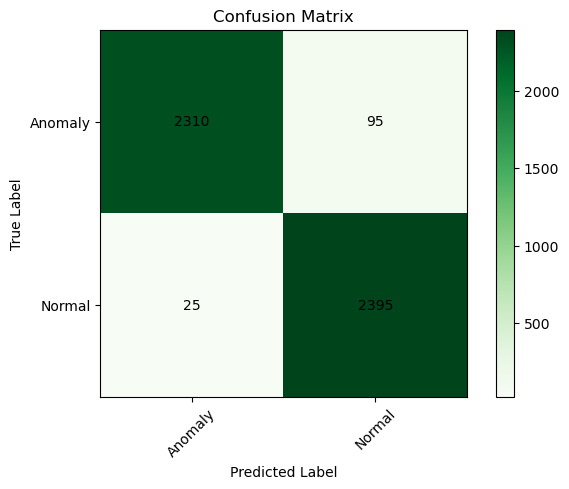

In [36]:
results = confusion_matrix(true_labels, pred_labels) 

print ('Confusion Matrix :')

utils.plot_confusion_matrix(results, ['Anomaly','Normal'])

# Test for all persons

In [37]:
def calc_accuracy(name: str):
    # Train Model
    transations = utils.get_person_balanced_df(df, name, categories, cat_vars, numeric_vars)
    df_transations = transations[0][0]
    labels = transations[1][0]
    x_train, x_test, y_train, y_test = train_test_split(df_transations, labels, test_size=.25, random_state=42)
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dtest = xgb.DMatrix(x_test, label=y_test)
    evals = [(dtest, 'test'), (dtrain, 'train')]
    model = xgb.train(params, dtrain, num_rounds, evals=evals)
    #Validation
    preds = model.predict(dtest)
    pred_labels = (preds > threshold).astype(int)
    true_labels = y_test.astype(int)
    return accuracy_score(true_labels, pred_labels)

In [40]:
persons = list(df['Cardholder Last Name'].unique())
quantities = df['Cardholder Last Name'].value_counts()
values = []
names = []

for person in persons:
    if quantities[person] > 2000:
        accuracy = calc_accuracy(person)
        values.append(accuracy) 
        names.append(quantities[person])

[0]	test-logloss:0.68071	train-logloss:0.67504
[1]	test-logloss:0.66886	train-logloss:0.66186
[2]	test-logloss:0.66552	train-logloss:0.65639
[3]	test-logloss:0.66382	train-logloss:0.65457
[4]	test-logloss:0.66270	train-logloss:0.65336
[5]	test-logloss:0.66159	train-logloss:0.65216
[6]	test-logloss:0.66159	train-logloss:0.65216
[7]	test-logloss:0.66065	train-logloss:0.65114
[8]	test-logloss:0.66065	train-logloss:0.65114
[9]	test-logloss:0.65408	train-logloss:0.64223
[10]	test-logloss:0.65408	train-logloss:0.64223
[11]	test-logloss:0.65408	train-logloss:0.64223
[12]	test-logloss:0.65408	train-logloss:0.64223
[13]	test-logloss:0.65408	train-logloss:0.64223
[14]	test-logloss:0.65408	train-logloss:0.64223
[15]	test-logloss:0.65408	train-logloss:0.64223
[16]	test-logloss:0.65408	train-logloss:0.64223
[17]	test-logloss:0.65408	train-logloss:0.64223
[18]	test-logloss:0.65408	train-logloss:0.64223
[19]	test-logloss:0.65408	train-logloss:0.64223
[0]	test-logloss:0.65859	train-logloss:0.65247
[1]

Text(0, 0.5, 'Accuracy')

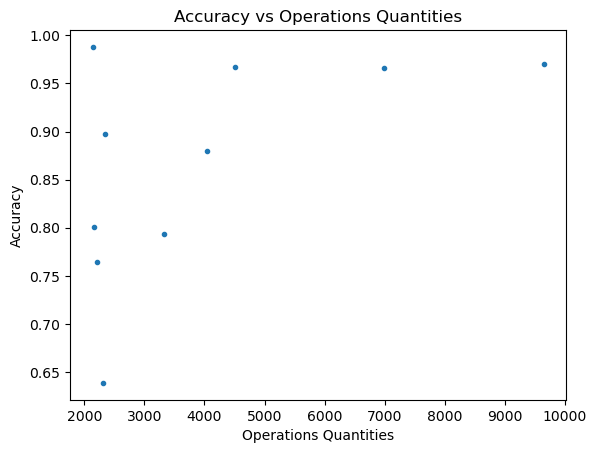

In [42]:
plt.figure()
plt.plot(names, values, ".")
plt.title("Accuracy vs Operations Quantities")
plt.xlabel("Operations Quantities")
plt.ylabel("Accuracy")